In [142]:
import astropy
from astropy.time import Time,TimezoneInfo
from astropy import units as u
from astropy import coordinates as co
import pandas as pd
from astroplan import Observer
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [223]:
nnights = 181
t = Time('2021-02-2') + arange(nnights) * u.day # UT date
df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
keck = Observer.at_site("Keck", timezone="US/Hawaii")
sunset = keck.sun_set_time(t,horizon=-12*u.deg,which='next')
sunrise =  keck.sun_rise_time(t,horizon=-12*u.deg, which='next')
moonrise = keck.moon_rise_time(t,horizon=0*u.deg, which='next')

In [312]:
nightlength = sunrise-sunset
df2 = []
for i in range(1,5):
    df = pd.DataFrame(dict(utdate=t.to_value('iso','date')))
    df['Date'] = (t - 1*u.day).to_value('iso','date')
    df['quarter'] = i
    start = sunset + (i-1) / 4.0 * nightlength
    stop = sunset +  i / 4.0 * nightlength
    df['nightlength'] = nightlength.value
    df['start_jd'] =  start.jd
    df['start'] = pd.Series(start.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['stop'] = pd.Series(stop.to_value('iso','date_hm')).str.slice(start=11,stop=16)
    df['moon_alt_start'] = keck.moon_altaz(start).alt.deg
    df['moon_alt_stop'] = keck.moon_altaz(stop).alt.deg
    df2.append(df)

df = pd.concat(df2)
df = df.sort_values(by=['start_jd'])
df = df.reset_index(drop=True)
df['dark'] = (df.moon_alt_start < 0) & (df.moon_alt_stop < 0) # determine darktime
calendar = df.copy()

In [313]:
df = calendar.copy()
dfrem = calendar.copy()

df['kpfcc'] = False
dark_early = df[df.quarter.isin([1,2])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_late = df[df.quarter.isin([3,4])].groupby('utdate').filter(lambda x: x['dark'].sum()==2)
dark_all = df.groupby('utdate').filter(lambda x: x['dark'].sum()==4)

rs = 0 
nstart_quarters = len(df)
nkpfcc_quarters = 181 
ndark_quarters = 181 # remove this many quarters for darktime

dfrem = dfrem.drop(dark_all.index,errors='ignore')
dfrem = dfrem.drop(dark_early.index,errors='ignore')
dfrem = dfrem.drop(dark_late.index,errors='ignore')

print("{}/{} quarters remain after dropping dark all, early, late".format(len(dfrem),nstart_quarters))

# schedule 1/8 of nights are first half

for i in range(4):
    if i==0:
        # schedule 1/8 of nights as Q1+Q2
        nnights_select = int(0.125 * nkpfcc_quarters)

        # remove dark early nights from consideration here.
        temp = dfrem[~dfrem.utdate.isin(dark_early.utdate.drop_duplicates())]
        dates = temp.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        print(sort(dates))
        df.loc[df.utdate.isin(dates) & (df.quarter.isin([1,2])),'kpfcc'] = True

    if i==1:
        # schedule 1/8 of nights as Q3+Q4
        nnights_select = int(0.125 * nkpfcc_quarters)
        temp = dfrem[~dfrem.utdate.isin(dark_late.utdate.drop_duplicates())]
        dates = temp.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([3,4]),'kpfcc'] = True

    if i==2:
        # schedule 1/4 of nights as Q1 
        nnights_select = int(0.25 * nkpfcc_quarters)
        temp = dfrem[(dfrem.quarter==1)&(~dfrem.dark)]
        dates = temp.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([1]),'kpfcc'] = True

    if i==3:
        # schedule 1/4 of nights as Q4
        nnights_select = int(0.25 * nkpfcc_quarters)
        temp = dfrem[(dfrem.quarter==4)&(~dfrem.dark)]
        dates = temp.utdate.drop_duplicates().sample(nnights_select,random_state=rs)
        df.loc[df.utdate.isin(dates) & df.quarter.isin([4]),'kpfcc'] = True

    dfrem = dfrem[~dfrem.utdate.isin(dates)]


print("{}/{} quarters are KPF-CC".format(df.kpfcc.sum(),nstart_quarters))
print("{}/{} nights KPF-CC onsky".format((df.groupby('utdate')['kpfcc'].sum()>0).sum(),nnights))
savecols = 'utdate quarter start stop kpfcc dark'.split()

sched_cc = df.copy()
sched_cc[savecols].to_csv('kpfcc_schedule_v3.csv')

496/724 quarters remain after dropping dark all, early, late
['2021-02-04' '2021-02-17' '2021-02-18' '2021-02-20' '2021-03-04'
 '2021-03-15' '2021-03-21' '2021-03-24' '2021-04-15' '2021-05-01'
 '2021-05-16' '2021-05-21' '2021-05-28' '2021-06-15' '2021-06-19'
 '2021-06-20' '2021-06-21' '2021-06-28' '2021-06-30' '2021-07-19'
 '2021-07-23' '2021-07-31']
178/724 quarters are KPF-CC
134/181 nights KPF-CC onsky


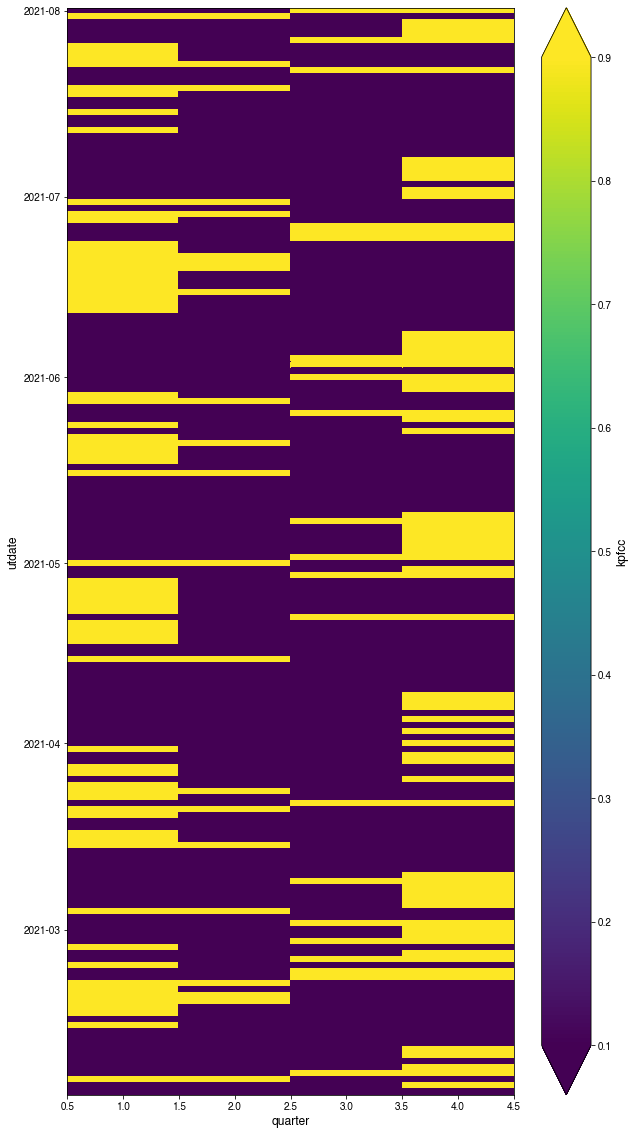

In [314]:
da = df.groupby(['utdate','quarter'])['kpfcc'].first().to_xarray()
da.coords['utdate'] = Time(list(array(da.utdate))).datetime
da.sortby(da.utdate,ascending=False).plot.pcolormesh(figsize=(10,20),vmin=0.1,vmax=0.9)

In [315]:
import pandas as pd

df = pd.read_csv('2021A-schedule.csv')
sched_cj_night = df.copy()
def shorten_name(s):
    names = s.split(' ')
    nnames = len(names)
    if nnames > 1:
        _out = " ".join([n[0] for n in names[:-1]] + [names[-1]])
    return _out

df['PIlast'] = df.PI.apply(lambda x : x.split(' ')[-1] )
dates = df.Date.drop_duplicates()
nnights = len(dates)
df['night_percent'] = df.Time.str.slice(start=-5,stop=-2).astype(int)

#df['PIlastnmae'] = df['PI'].
df['numq'] = (df.night_percent * 4/100).round()
df2 = []
for i, row in df.iterrows():
    for i in range(int(row.numq)):
        df2.append(row)
df2 = pd.concat(df2,axis=1).T
df = df2.reset_index() 
df['quarter'] = hstack([arange(1,5)]*nnights)
assert len(df.groupby('Date')['quarter'].nunique().drop_duplicates())==1, False
df = pd.merge(df,calendar['Date quarter dark'.split()]) # merge in dark info
sched_cj = df.copy()

In [316]:
sched_cj.head(20)


,index,Date,Time,Dark,TelNr,Instrument,Account,PI,Institution,ProjCode,Unnamed: 9,PIlast,night_percent,numq,quarter,dark
0,0,2021-02-01,05:03 - 16:08 (100%),28,1,OSIRIS-LGS,osiris6,George Djorgovski,CIT,C311,NaN,Djorgovski,100,4.0,1,True
1,0,2021-02-01,05:03 - 16:08 (100%),28,1,OSIRIS-LGS,osiris6,George Djorgovski,CIT,C311,NaN,Djorgovski,100,4.0,2,False
2,0,2021-02-01,05:03 - 16:08 (100%),28,1,OSIRIS-LGS,osiris6,George Djorgovski,CIT,C311,NaN,Djorgovski,100,4.0,3,False
3,0,2021-02-01,05:03 - 16:08 (100%),28,1,OSIRIS-LGS,osiris6,George Djorgovski,CIT,C311,NaN,Djorgovski,100,4.0,4,False
4,1,2021-02-02,05:04 - 10:36 ( 50%),37,1,OSIRIS-NGS,osiris7,Michihiro Takami,Subaru,S364,NaN,Takami,50,2.0,1,True
5,1,2021-02-02,05:04 - 10:36 ( 50%),37,1,OSIRIS-NGS,osiris7,Michihiro Takami,Subaru,S364,NaN,Takami,50,2.0,2,False
6,2,2021-02-02,10:36 - 16:08 ( 50%),37,1,OSIRIS-LGS,osiris7,Duncan Farrah,UH,H319,NaN,Farrah,50,2.0,3,False
7,2,2021-02-02,10:36 - 16:08 ( 50%),37,1,OSIRIS-LGS,osiris7,Duncan Farrah,UH,H319,NaN,Farrah,50,2.0,4,False
8,3,2021-02-03,05:04 - 10:36 ( 50%),46,1,OSIRIS-NGS,osiris7,Michihiro Takami,Subaru,S364,NaN,Takami,50,2.0,1,True
9,3,2021-02-03,05:04 - 10:36 ( 50%),46,1,OSIRIS-NGS,osiris7,Michihiro Takami,Subaru,S364,NaN,Takami,50,2.0,2,False


In [317]:
dates = sched_cj.Date.drop_duplicates()
df_cj = sched_cj.groupby(['Date','quarter']).first()
df_cc = sched_cc.groupby(['Date','quarter']).first()
df_cj_night = sched_cj_night.groupby(['Date']).first()

df_out = pd.DataFrame(index=dates)
for date in dates:
    df_out.loc[date,'dark'] = df_cj_night.loc[date,'Dark']
    for quarter in range(1,5):
        row = df_cj.loc[date,quarter]
        d = dict(**row)
        d['dark'] = int(d['dark'])
        d['date'] = date
        d['quarter'] = quarter
        s = "{PIlast:}, {Instrument}, {ProjCode}, date={date}, dark={dark}, q={quarter}".format(**d)
        df_out.loc[date,'schedule_old{}'.format(quarter)] = s
        df_out.loc[date,'dark{}'.format(quarter)] = int(row.dark)

        df_out.loc[date,'kpfcc{}'.format(quarter)] = int(df_cc.loc[date,quarter].kpfcc)
        df_out.loc[date,'schedule_new{}'.format(quarter)] = ''
        print(s)
        
for quarter in range(1,5):
    df_out.loc[:,'dark{}'.format(quarter)] = df_out.loc[:,'dark{}'.format(quarter)].astype(int)
    
df_out['x'] = '' # blank for spacing 

cols = []
cols+=['dark']
for i in range(1,5):
    cols += ['schedule_old{}'.format(i),'dark{}'.format(i)]

cols += ['x']
for i in range(1,5):
    cols += ['kpfcc{}'.format(i)]
    cols += ['schedule_new{}'.format(i)]
    cols += ['x']*3 # three blank columns
    
df_out[cols].to_excel('2021A_mock-schedule.xlsx')

Djorgovski, OSIRIS-LGS, C311, date=2021-02-01, dark=1, q=1
Djorgovski, OSIRIS-LGS, C311, date=2021-02-01, dark=0, q=2
Djorgovski, OSIRIS-LGS, C311, date=2021-02-01, dark=0, q=3
Djorgovski, OSIRIS-LGS, C311, date=2021-02-01, dark=0, q=4
Takami, OSIRIS-NGS, S364, date=2021-02-02, dark=1, q=1
Takami, OSIRIS-NGS, S364, date=2021-02-02, dark=0, q=2
Farrah, OSIRIS-LGS, H319, date=2021-02-02, dark=0, q=3
Farrah, OSIRIS-LGS, H319, date=2021-02-02, dark=0, q=4
Takami, OSIRIS-NGS, S364, date=2021-02-03, dark=1, q=1
Takami, OSIRIS-NGS, S364, date=2021-02-03, dark=0, q=2
Farrah, OSIRIS-LGS, H319, date=2021-02-03, dark=0, q=3
Farrah, OSIRIS-LGS, H319, date=2021-02-03, dark=0, q=4
Nanayakkara, MOSFIRE, W242, date=2021-02-04, dark=1, q=1
Nanayakkara, MOSFIRE, W242, date=2021-02-04, dark=1, q=2
Nanayakkara, MOSFIRE, W242, date=2021-02-04, dark=0, q=3
Nanayakkara, MOSFIRE, W242, date=2021-02-04, dark=0, q=4
Kelly, MOSFIRE, N201, date=2021-02-05, dark=1, q=1
Kelly, MOSFIRE, N201, date=2021-02-05, dark=1

Dokkum, LRIS-ADC, Y228, date=2021-04-15, dark=1, q=4
Kirby, MOSFIRE, C259, date=2021-04-16, dark=0, q=1
Kirby, MOSFIRE, C259, date=2021-04-16, dark=0, q=2
Kirby, MOSFIRE, C259, date=2021-04-16, dark=1, q=3
Kirby, MOSFIRE, C259, date=2021-04-16, dark=1, q=4
Hennawi, MOSFIRE, U058, date=2021-04-17, dark=0, q=1
Hennawi, MOSFIRE, U058, date=2021-04-17, dark=0, q=2
Hennawi, MOSFIRE, U058, date=2021-04-17, dark=1, q=3
Hennawi, MOSFIRE, U058, date=2021-04-17, dark=1, q=4
Shapley, MOSFIRE, U046, date=2021-04-18, dark=0, q=1
Shapley, MOSFIRE, U046, date=2021-04-18, dark=0, q=2
Shapley, MOSFIRE, U046, date=2021-04-18, dark=0, q=3
Shapley, MOSFIRE, U046, date=2021-04-18, dark=1, q=4
Siana, MOSFIRE, U122, date=2021-04-19, dark=0, q=1
Siana, MOSFIRE, U122, date=2021-04-19, dark=0, q=2
Siana, MOSFIRE, U122, date=2021-04-19, dark=0, q=3
Siana, MOSFIRE, U122, date=2021-04-19, dark=1, q=4
Treu, MOSFIRE, U020, date=2021-04-20, dark=0, q=1
Treu, MOSFIRE, U020, date=2021-04-20, dark=0, q=2
Treu, MOSFIRE, 

Engineering, LRIS-ADC, E376, date=2021-06-25, dark=0, q=4
Ruffio, OSIRIS-NGS, C292, date=2021-06-26, dark=0, q=1
Ruffio, OSIRIS-NGS, C292, date=2021-06-26, dark=0, q=2
Engineering, OSIRIS-LGS, E333, date=2021-06-26, dark=0, q=3
Engineering, OSIRIS-LGS, E333, date=2021-06-26, dark=0, q=4
Ruffio, OSIRIS-NGS, C292, date=2021-06-27, dark=1, q=1
Ruffio, OSIRIS-NGS, C292, date=2021-06-27, dark=0, q=2
Engineering, MOSFIRE, E395, date=2021-06-27, dark=0, q=3
Engineering, MOSFIRE, E395, date=2021-06-27, dark=0, q=4
Ravi, MOSFIRE, C310, date=2021-06-28, dark=1, q=1
Ravi, MOSFIRE, C310, date=2021-06-28, dark=0, q=2
Ravi, MOSFIRE, C310, date=2021-06-28, dark=0, q=3
Ravi, MOSFIRE, C310, date=2021-06-28, dark=0, q=4
Batalha, HIRESr, U111, date=2021-06-29, dark=1, q=1
Batalha, HIRESr, U111, date=2021-06-29, dark=0, q=2
Batalha, HIRESr, U111, date=2021-06-29, dark=0, q=3
Batalha, HIRESr, U111, date=2021-06-29, dark=0, q=4
Duchene, OSIRIS-NGS, U032, date=2021-06-30, dark=1, q=1
Duchene, OSIRIS-NGS, U03